In [9]:
from typing import Callable, List
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt

type FunctionParameter = Callable[[npt.NDArray[np.float64], float], float]
def FirstOrderSchemeIntegrator(
    X_0: List[float],
    A_i_funcs: List[FunctionParameter],
    B_i_j_funcs: List[List[FunctionParameter]], # This must be a square array
    T: float,
    N: int,
    rng: np.random.Generator
):
    X_0_dim = len(X_0)
    A_i_funcs_dim = len(A_i_funcs)
    B_i_j_funcs_row_dim = len(B_i_j_funcs)
    B_i_j_funcs_col_dim = len(B_i_j_funcs[0])
    assert X_0_dim == A_i_funcs_dim == B_i_j_funcs_row_dim ==  B_i_j_funcs_col_dim
    dim = X_0_dim
    
    times = np.linspace(0.0, T, N + 1)
    delta = T / N
    Z = rng.normal(loc=0, scale=1.0, size=(dim, N))
    paths = np.zeros(shape=(dim, N + 1))
    paths[:, 0] = X_0
    for i in range(N):
        t = times[i]
        
        A_values = np.array([A_i_funcs[j](paths[:, i], t) for j in range(dim)]).T
        B_values = np.array([sum(B_i_j_funcs[j][k](paths[:, i], t) for k in range(dim)) for j in range(dim)]).T
        
        paths[:, i + 1] = abs(paths[:, i] + delta * A_values + np.sqrt(delta) * Z[:, i] * B_values)
    
    return paths


In [10]:
S_0 = 100
V_0 = 0.1
r = 0.05
kappa = 2.0
theta = 0.2
sigma_1 = 0.2
sigma_2 = 0.3
T = 1
N = 252

a_1: FunctionParameter = lambda X_t, t: r * X_t[0]
a_2: FunctionParameter = lambda X_t, t: kappa * (theta - X_t[1])

b_1_1: FunctionParameter = lambda X_t, t: np.sqrt(X_t[1]) * X_t[0]
b_1_2: FunctionParameter = lambda X_t, t: 0

b_2_1: FunctionParameter = lambda X_t, t: np.sqrt(X_t[1]) * sigma_1
b_2_2: FunctionParameter = lambda X_t, t: np.sqrt(X_t[1]) * sigma_2

rng = np.random.default_rng()

In [11]:
retval = FirstOrderSchemeIntegrator(
    X_0 = [S_0, V_0],
    A_i_funcs = [a_1, a_2],
    B_i_j_funcs = [[b_1_1, b_1_2], [b_2_1, b_2_2]],
    T=T,
    N=N,
    rng=rng
)

stock_path = retval[0]
volatility_path = retval[1]
differenced_stock_price = np.diff(stock_path)
normalized_differenced_stock_price = differenced_stock_price / volatility_path[:-1]


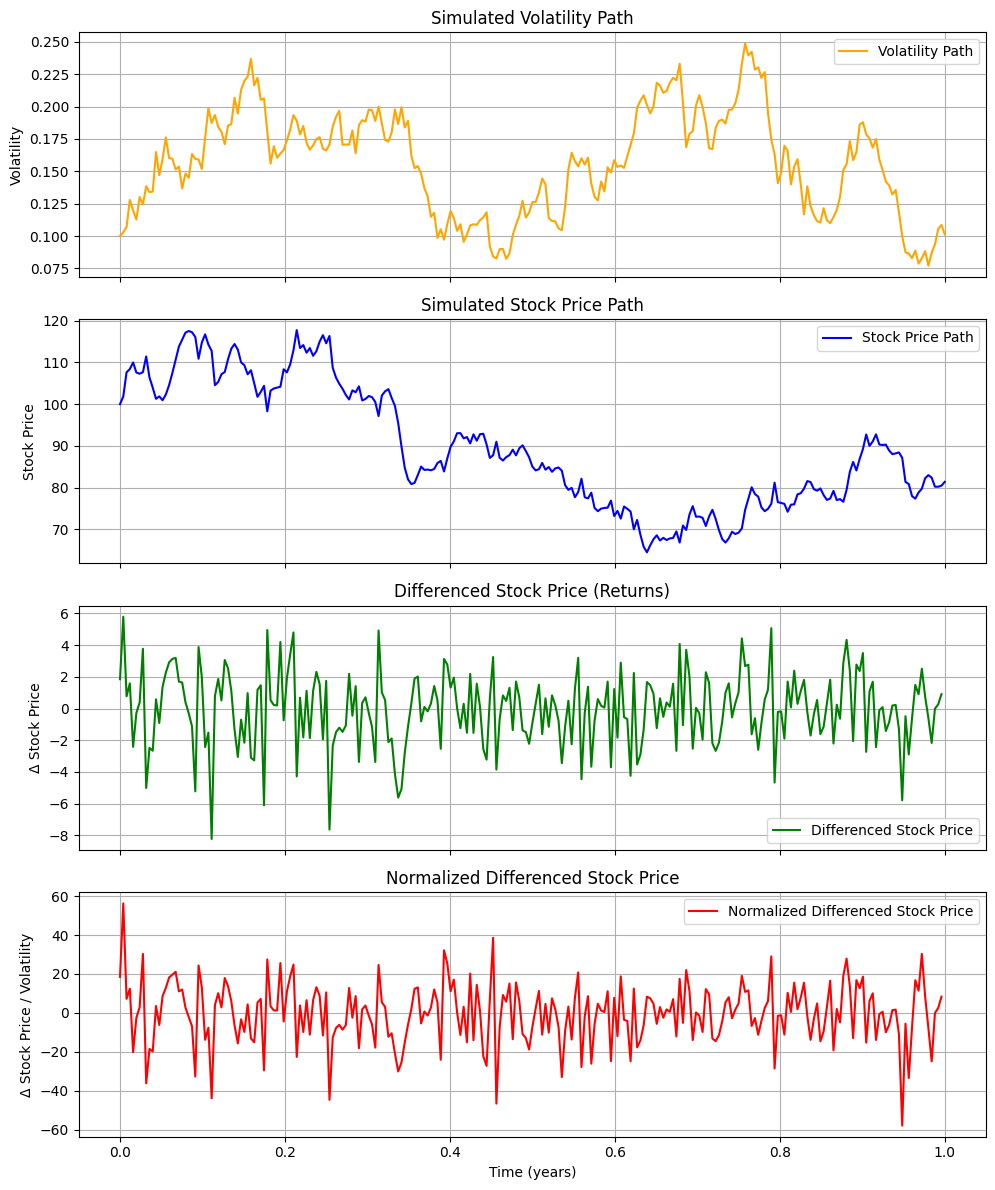

In [12]:
time_values = np.linspace(0, T, N + 1)
time_values_diff = time_values[:-1]  # Adjusted time for differenced series

# Create a figure with four subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

# Plot volatility path
axs[0].plot(time_values, volatility_path, color="orange", label="Volatility Path")
axs[0].set_ylabel("Volatility")
axs[0].set_title("Simulated Volatility Path")
axs[0].legend()
axs[0].grid(True)

# Plot stock price path
axs[1].plot(time_values, stock_path, color="blue", label="Stock Price Path")
axs[1].set_ylabel("Stock Price")
axs[1].set_title("Simulated Stock Price Path")
axs[1].legend()
axs[1].grid(True)

# Plot differenced stock price
axs[2].plot(time_values_diff, differenced_stock_price, color="green", label="Differenced Stock Price")
axs[2].set_ylabel("Δ Stock Price")
axs[2].set_title("Differenced Stock Price (Returns)")
axs[2].legend()
axs[2].grid(True)

# Plot normalized differenced stock price (returns divided by volatility)
axs[3].plot(time_values_diff, normalized_differenced_stock_price, color="red", label="Normalized Differenced Stock Price")
axs[3].set_xlabel("Time (years)")
axs[3].set_ylabel("Δ Stock Price / Volatility")
axs[3].set_title("Normalized Differenced Stock Price")
axs[3].legend()
axs[3].grid(True)

# Display the plots
plt.tight_layout()
plt.show()